# **PyTorch Workflow Fundamentals**

The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discovered patterns to predict the future. There are many ways to do this and many new ways are being discovered all the time.

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

## **1. Data Prepration & Data Loading**

It's worth stressing that "data" in machine learning can be almost anything we can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more. Machine learning is a game of two parts: 
1. Turn our data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

Sometimes one and two can be done at the same time. Right now we don't have any data so we can create some. Let's create our data as a straight line. We'll use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to create the data with known **parameters** (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using [**gradient descent**](https://en.wikipedia.org/wiki/Gradient_descent).

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### **Splitting Data**

We've got some data. But before we build a model we need to split it up. One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set). Each split of the dataset serves a specific purpose:

| Split | Purpose | Amount of total data | How often is it used? |
| ----- | ----- | ----- | ----- |
| **Training set** | The model learns from this data (like the course materials you study during the semester). | $\approx60-80\%$ | Always |
| **Validation set** | The model gets tuned on this data (like the practice exam you take before the final exam). | $\approx10-20\%$ | Often but not always |
| **Testing set** | The model gets evaluated on this data to test what it has learned (like the final exam you take at the end of the semester). | $\approx10-20\%$ | Always |

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on. We can create them by splitting our `X` and `y` tensors. When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

We've got $40$ samples for training (`X_train` & `y_train`) and $10$ samples for testing (`X_test` & `y_test`). The model we create is going to try and learn the relationship between `X_train` & `y_train` and then we will evaluate what it learns on `X_test` and `y_test`.

In [4]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14});

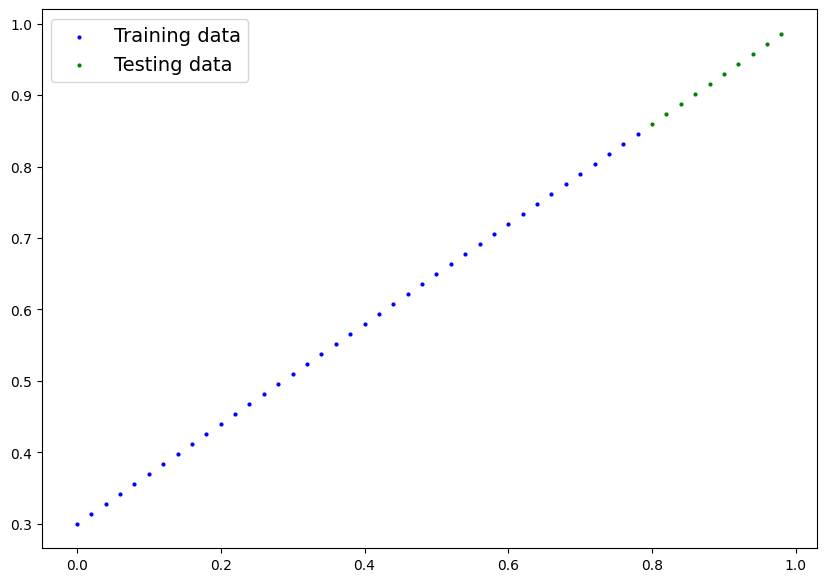

In [5]:
plot_predictions()

## **2. Build Model**

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True) 

        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32), requires_grad=True) 

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        return self.weights * x + self.bias 

### **PyTorch model building essentials**

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html). For now, we'll focus on the first two and get to the other two later.

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  | 
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data 

![a pytorch linear model with annotations](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-model-annotated.png)
*Basic building blocks of creating a PyTorch model by subclassing `nn.Module`. For objects that subclass `nn.Module`, the `forward()` method must be defined.*

### **Checking the Contents a Model**

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

We can get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict). Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors? This is because we initialized them above using `torch.randn()`. Essentially we want to start from random parameters and get the model to update them towards parameters that fit our data best (the hardcoded `weight` and `bias` values we set when creating our straight line data). Because our model starts with random values, right now it'll have poor predictive power.

### **Making Predictions**

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`. When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined. Let's make some predictions. We use [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) as a [context manager](https://realpython.com/python-with-statement/) (that's what the `with torch.inference_mode():` is) to make the predictions. As the name suggests, `torch.inference_mode()` is used when using a model for inference (making predictions). `torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the `forward()` method) faster. We've made some predictions, let's see what they look like. 

In [9]:
with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [10]:
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


Notice how there's one prediction value per testing sample. This is because of the kind of data we're using. For our straight line, one `X` value maps to one `y` value. However, machine learning models are very flexible. You could have 100 `X` values mapping to one, two, three or 10 `y` values. It all depends on what you're working on. Our predictions are still numbers on a page, let's visualize them with our `plot_predictions()` function we created above.

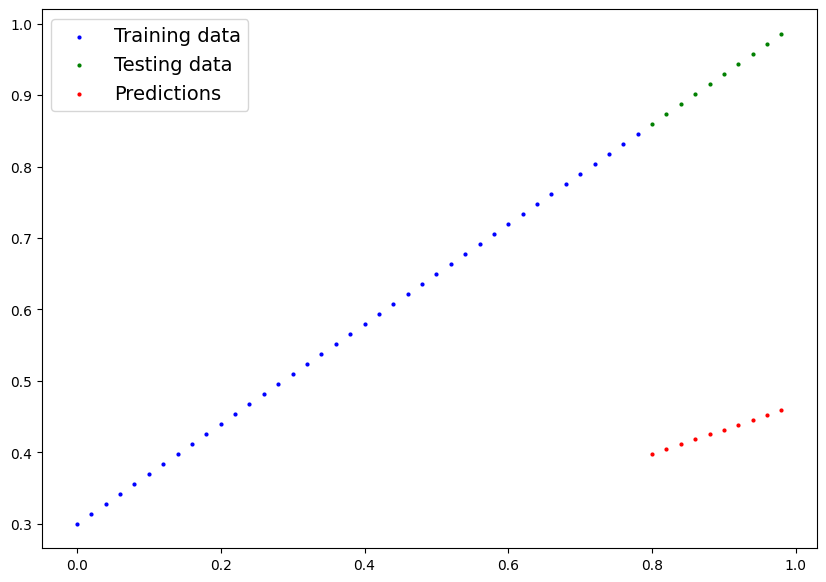

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

Those predictions look pretty bad. This makes sense though, when you remember our model is just using random parameter values to make predictions. It hasn't even looked at the blue dots to try to predict the green dots. Time to change that.

## **3. Train Model**

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly). To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

### **Creating a Loss function & Optimizer**

For our model to update its parameters on its own, we'll need to add a few more things to our recipe. And that's a **loss function** as well as an **optimizer**.

The rolls of these are: 

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong our model's predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  |
| **Optimizer** | Tells our model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). | 

Let's create a loss function and an optimizer we can use to help improve our model. Depending on what kind of problem we're working on it will depend on what loss function and what optimizer we use. However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another). For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) in PyTorch as our loss function.  And we'll use SGD, `torch.optim.SGD(params, lr)` where:

* `params` is the target model parameters we'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
* `lr` is the **learning rate** we'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are `0.01`, `0.001`, `0.0001`, however, these can also be adjusted over time (this is called [learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)). 

In [13]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### **Creating an Optimization Loop**

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`. The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training). Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset. To create these we're going to write a Python `for` loop in the theme of the [unofficial PyTorch optimization loop song](https://twitter.com/mrdbourke/status/1450977868406673410?s=20) (there's a [video version too](https://youtu.be/Nutpusq_AFw)).

### **PyTorch Training Loop**

For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| $1$ | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| $3$ | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| $4$ | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| $5$ | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png)

Some rules of thumb: 
- Calculate the loss (`loss = ...`) *before* performing backpropagation on it (`loss.backward()`).
- Zero gradients (`optimizer.zero_grad()`) *before* computing the gradients of the loss with respect to every model parameter (`loss.backward()`).
- Step the optimizer (`optimizer.step()`) *after* performing backpropagation on the loss (`loss.backward()`).

### **PyTorch Testing Loop**

As for the testing loop (evaluating our model), the typical steps include:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| $1$ | Forward pass | The model goes through all of the testing data once, performing its `forward()` function calculations. | `model(x_test)` |
| $2$ | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_test)` | 
| $3$ | Calulate evaluation metrics (optional) | Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. | Custom functions |

Notice the testing loop doesn't contain performing backpropagation (`loss.backward()`) or stepping the optimizer (`optimizer.step()`), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

![pytorch annotated testing loop](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-testing-loop-annotated.png)

In [14]:
torch.manual_seed(42)

epochs = 100
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()

    with torch.inference_mode():
      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred, y_test.type(torch.float))
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288135051727295 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713389158249 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.2172965705394745 
Epoch: 30 | MAE Train Loss: 0.053148530423641205 | MAE Test Loss: 0.14464019238948822 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953748226166 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633813381195 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937722325325 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.027887403964996338 | MAE Test Loss: 0.06473556160926819 


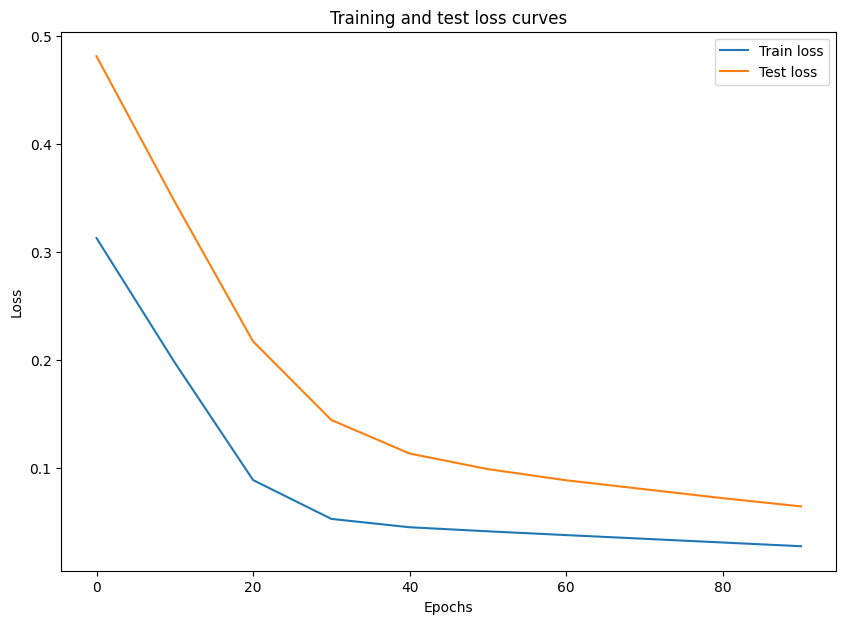

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

The **loss curves** show the loss going down over time. Remember, loss is the measure of how *wrong* your model is, so the lower the better. But why did the loss go down? Well, thanks to our loss function and optimizer, the model's internal parameters (`weights` and `bias`) were updated to better reflect the underlying patterns in the data. Let's inspect our model's [`.state_dict()`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) to see how close our model gets to the original values we set for weights and bias.

In [16]:
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5784]), 'bias': tensor([0.3513])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


Our model got very close to calculating the exact original values for `weight` and `bias` (and it would probably get even closer if we trained it for longer). It'd likely never guess them *perfectly* (especially when using more complicated datasets) but that's okay, often we can do a lot of things with a close approximation. This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically**.

In [17]:
torch.manual_seed(42)

epochs = 400
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()

    with torch.inference_mode():
      test_pred = model_0(X_test)
      test_loss = loss_fn(test_pred, y_test.type(torch.float))
      if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

print("\nThe model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

Epoch: 0 | MAE Train Loss: 0.024458955973386765 | MAE Test Loss: 0.056463055312633514 
Epoch: 100 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 200 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 
Epoch: 300 | MAE Train Loss: 0.00893248151987791 | MAE Test Loss: 0.005023092031478882 

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## **4. Making Predictions**

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (`model.eval()`).
2. Make the predictions using the inference mode context manager (`with torch.inference_mode(): ...`).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [18]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

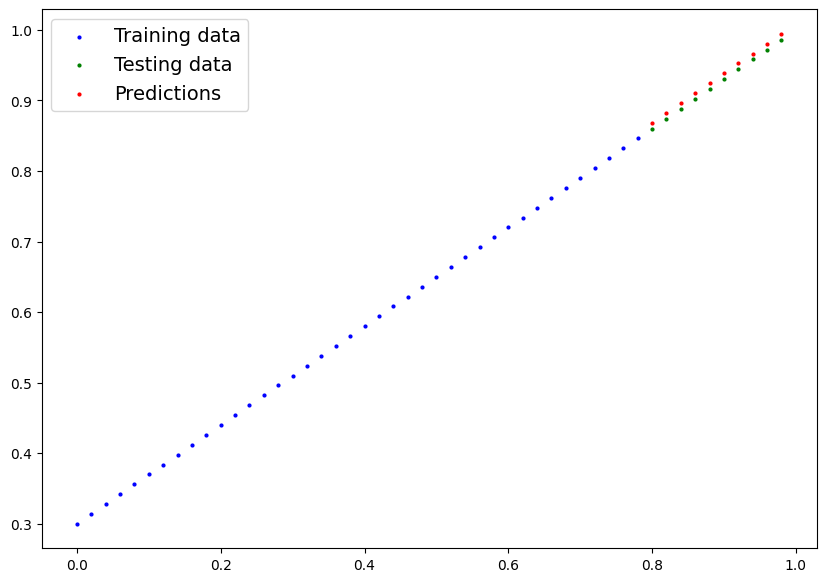

In [19]:
plot_predictions(predictions=y_preds)

## **5. Saving & Loading Models**

For saving and loading models in PyTorch, there are three main methods we should be aware of (all of below have been taken from the [PyTorch saving and loading models guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)):

| PyTorch method | What does it do? | 
| ----- | ----- |
| [`torch.save`](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) | Saves a serialized object to disk using Python's [`pickle`](https://docs.python.org/3/library/pickle.html) utility. Models, tensors and various other Python objects like dictionaries can be saved using `torch.save`.  | 
| [`torch.load`](https://pytorch.org/docs/stable/torch.html?highlight=torch%20load#torch.load) | Uses `pickle`'s unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc). |
| [`torch.nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=load_state_dict#torch.nn.Module.load_state_dict)| Loads a model's parameter dictionary (`model.state_dict()`) using a saved `state_dict()` object. | 

**Note:** As stated in [Python's `pickle` documentation](https://docs.python.org/3/library/pickle.html), the `pickle` module **is not secure**. That means we should only ever unpickle (load) data we trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.

### **Saving Model's `state_dict()`**

The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`. Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to called `models` using Python's `pathlib` module.
2. We'll create a file path to save the model to.
3. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the filename of where to save the model.

**Note:** It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.

In [20]:
from pathlib import Path

MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Model_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: Models/Model_01.pth


### **Loading Saved Model's `state_dict()`**

Since we've now got a saved model `state_dict()` at `Models/Model_01.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`. Why call `torch.load()` inside `torch.nn.Module.load_state_dict()`?  Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the *entire* model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of `nn.Module`).

Why not save the entire model? [Saving the entire model](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model) rather than just the `state_dict()` is more intuitive, however, to quote the PyTorch documentation:

> The disadvantage of this approach *(saving the whole model)* is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved...
> Because of this, your code can break in various ways when used in other projects or after refactors.

So instead, we're using the flexible method of saving and loading just the `state_dict()`, which again is basically a dictionary of model parameters. Let's test it out by creating another instance of `LinearRegressionModel()`, which is a subclass of `torch.nn.Module` and will hence have the in-built method `load_state_dict()`.

In [21]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [22]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) 

In [23]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Nice!  It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected. There are more methods to save and load PyTorch models but let's leave these for extra-curriculum and further reading. See the [PyTorch guide for saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models) for more. 

## **6. Putting it All Together**

In [24]:
torch.__version__

'2.8.0'

In [25]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


### **6.1 Data**

Let's create some data just like before. First, we'll hard-code some `weight` and `bias` values. Then we'll make a range of numbers between $0$ and $1$, these will be our `X` values. Finally, we'll use the `X` values, as well as the `weight` and `bias` values to create `y` using the linear regression formula (`y = weight * X + bias`).

In [26]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [27]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

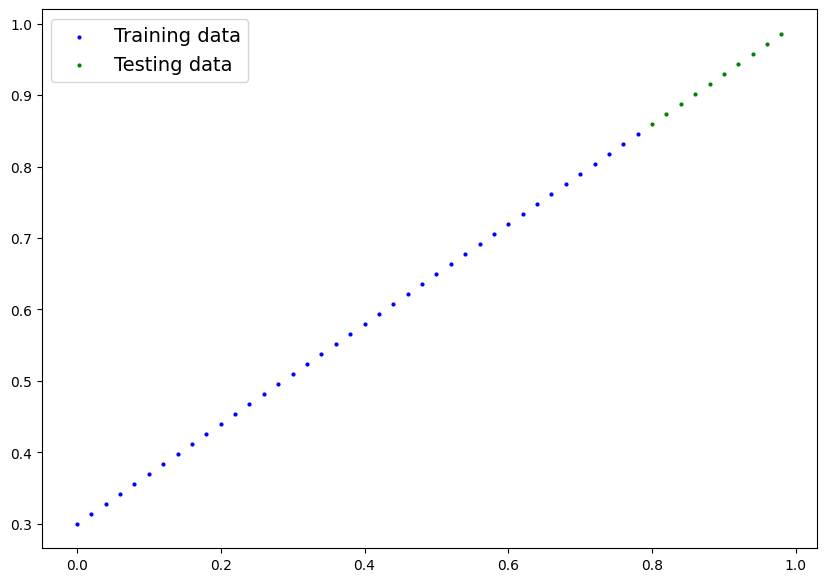

In [28]:
plot_predictions(X_train, y_train, X_test, y_test)

### **6.2 Building a Linear Model**

We've got some data, now it's time to make a model. We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use [`nn.Linear(in_features, out_features)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to do it for us. Where `in_features` is the number of dimensions your input data has and `out_features` is the number of dimensions you'd like it to be output to. In our case, both of these are `1` since our data has `1` input feature (`X`) per label (`y`).

![comparison of nn.Parameter Linear Regression model and nn.Linear Linear Regression model](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-linear-regression-model-with-nn-Parameter-and-nn-Linear-compared.png)
*Creating a linear regression model using `nn.Parameter` versus using `nn.Linear`. There are plenty more examples of where the `torch.nn` module has pre-built computations, including many popular and useful neural network layers.*


In [29]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Notice the outputs of `model_1.state_dict()`, the `nn.Linear()` layer created a random `weight` and `bias` parameter for us. Now let's put our model on the GPU (if it's available). We can change the device our PyTorch objects are on using `.to(device)`.

In [30]:
next(model_1.parameters()).device

device(type='cpu')

In [31]:
model_1.to(device) 
next(model_1.parameters()).device

device(type='mps', index=0)

### **6.3 Training**

Time to build a training and testing loop. First we'll need a loss function and an optimizer. Let's use the same functions we used earlier, `nn.L1Loss()` and `torch.optim.SGD()`. We'll have to pass the new model's parameters (`model.parameters()`) to the optimizer for it to adjust them during training.  The learning rate of `0.01` worked well before too so let's use that again.

In [32]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

Now let's train and evaluate our model using a training and testing loop. The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target `device`. We've already put our model on the target `device` using `model_1.to(device)`. And we can do the same with the data. That way if the model is on the GPU, the data is on the GPU (and vice versa). Let's step things up a notch this time and set `epochs=1000`.

In [33]:
torch.manual_seed(42)

epochs = 1000 
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

    model_1.train() 
    y_pred = model_1(X_train)           # 1. Forward pass
    loss = loss_fn(y_pred, y_train)     # 2. Calculate loss
    optimizer.zero_grad()               # 3. Zero grad optimizer
    loss.backward()                     # 4. Loss backward
    optimizer.step()                    # 5. Step the optimizer

    model_1.eval() 
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch: 100 | Train loss: 0.006215682718902826 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904


**Note:** Due to the random nature of machine learning, we will likely get slightly different results (different loss and prediction values) depending on whether our model was trained on CPU or GPU. This is true even if we use the same random seed on either device. If the difference is large, we may want to look for errors, however, if it is small (ideally it is), we can just ignore it. Now, let's check the parameters our model has learned and compare them to the original parameters we hard-coded.

In [34]:
from pprint import pprint 

print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


That's really close to a perfect model. Remember though, in practice, it's rare that we'll know the perfect parameters ahead of time. And if we knew the parameters our model had to learn ahead of time, what would be the point of machine learning? Plus, in many real-world machine learning problems, the number of parameters can well exceed tens of millions.

### **6.4 Making Predictions**

In [35]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

If you're making predictions with data on the GPU, you might notice the output of the above has `device='cuda:0'` or `device='mps:0'` towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.  Now let's plot our model's predictions. Many data science libraries such as pandas, matplotlib and NumPy aren't capable of using data that is stored on GPU. So we might run into some issues when trying to use a function from one of these libraries with tensor data not stored on the CPU. To fix this, we can call [`.cpu()`](https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html) on your target tensor to return a copy of your target tensor on the CPU.

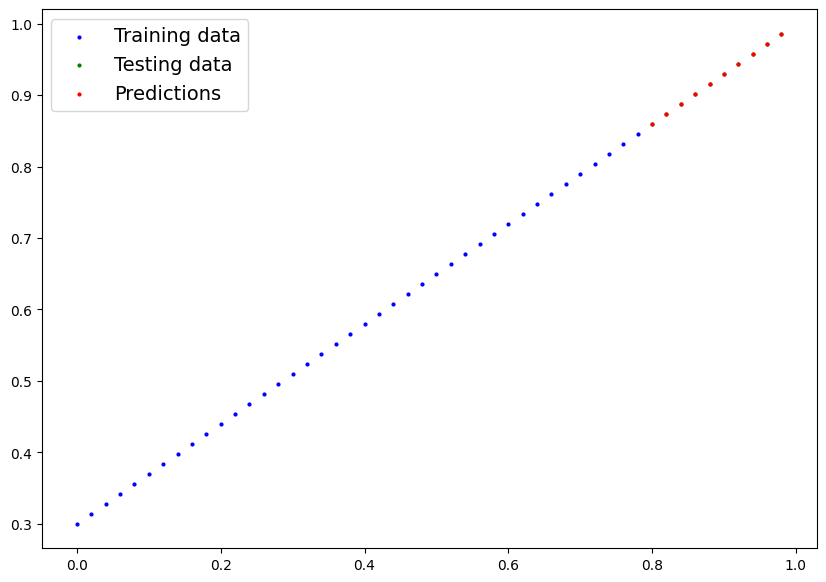

In [36]:
plot_predictions(predictions=y_preds.cpu())

### **6.5 Saving & Loading a Model**

In [37]:
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "Model_02.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH) 

Saving model to: Models/Model_02.pth


And just to make sure everything worked well, let's load it back in. We'll:
* Create a new instance of the `LinearRegressionModelV2()` class
* Load in the model state dict using `torch.nn.Module.load_state_dict()`
* Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [38]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


In [39]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')

## **Exercises**

All exercises have been inspired from code throughout the notebook. There is one exercise per major section. You should be able to complete them by referencing their specific section.

> **Note:** For all exercises, your code should be device agnostic (meaning it could run on CPU or GPU if it's available).

1. Create a straight line dataset using the linear regression formula (`weight * X + bias`).
  * Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total. 
  * Split the data into 80% training, 20% testing.
  * Plot the training and testing data so it becomes visual.
2. Build a PyTorch model by subclassing `nn.Module`. 
  * Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`. 
  * Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1. 
  * Once you've constructed the model, make an instance of it and check its `state_dict()`.
  * **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.
3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively. 
  * Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
  * Write a training loop to perform the appropriate training steps for 300 epochs.
  * The training loop should test the model on the test dataset every 20 epochs.
4. Make predictions with the trained model on the test data.
  * Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are *not* on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).
5. Save your trained model's `state_dict()` to file.
  * Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
  * Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

> **Resource:** See the [exercises notebooks templates](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/exercises) and [solutions](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) on the course GitHub.

## **Extra-curriculum**
* Listen to [The Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) (to help remember the steps in a PyTorch training/testing loop).
* Read [What is `torch.nn`, really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard for a deeper understanding of how one of the most important modules in PyTorch works. 
* Spend 10-minutes scrolling through and checking out the [PyTorch documentation cheatsheet](https://pytorch.org/tutorials/beginner/ptcheat.html) for all of the different PyTorch modules you might come across.
* Spend 10-minutes reading the [loading and saving documentation on the PyTorch website](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to become more familiar with the different saving and loading options in PyTorch. 
* Spend 1-2 hours reading/watching the following for an overview of the internals of gradient descent and backpropagation, the two main algorithms that have been working in the background to help our model learn. 
 * [Wikipedia page for gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)
 * [Gradient Descent Algorithm — a deep dive](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21) by Robert Kwiatkowski
 * [Gradient descent, how neural networks learn video](https://youtu.be/IHZwWFHWa-w) by 3Blue1Brown
 * [What is backpropagation really doing?](https://youtu.be/Ilg3gGewQ5U) video by 3Blue1Brown
 * [Backpropagation Wikipedia Page](https://en.wikipedia.org/wiki/Backpropagation)


---